<a href="https://colab.research.google.com/github/ElenaBetelgeuse/Computer-vision-Adversarial-attacks-/blob/main/Computer_vision_Adversarial_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Задание
Возьмите MNIST, обучите на нем LeNet

Обучите шум, который при добавлении к оригинальной картинке MNIST, заставит модель ошибаться в пользу другого класса

### 1. Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import random

import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 2. Загрузка данных

In [ ]:
def load_mnist():
    train_data = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                                            ]))
    test_data = datasets.MNIST('data', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                                            ]))
    return train_data, test_data

In [ ]:
def load_data(batch_size):
    train_data, test_data = load_mnist()
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=False)

    return (train_loader, test_loader)

### 3. MNIST to LeNet



#### 3.1. Конфигурация и базовые функции

##### https://www.kaggle.com/vincentman0403/pytorch-v0-3-1b-on-mnist-by-lenet

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train(model, optimizer, epoch, train_loader, log_interval):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    for batch_index, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_fn = torch.nn.CrossEntropyLoss()#size_average=False)
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss = loss_fn(output, target)
        pred = np.argmax(output.data, axis=1)
        correct = correct + np.equal(pred, target.data).sum()
    test_loss /= len(test_loader.dataset)
    print('Test set, Epoch {} , Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### 3.2.  Обучение LeNet

In [ ]:
torch.manual_seed(123)

model = LeNet()

lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr)

batch_size  = 1000
train_loader, test_loader = load_data(batch_size)

epochs = 5
log_interval = 100
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader, log_interval=log_interval)
    test(model, epoch, test_loader)

Test set, Epoch 1 , Average loss: 0.0001, Accuracy: 7917/10000 (79%)
Test set, Epoch 2 , Average loss: 0.0000, Accuracy: 9362/10000 (94%)
Test set, Epoch 3 , Average loss: 0.0000, Accuracy: 9568/10000 (96%)
Test set, Epoch 4 , Average loss: 0.0000, Accuracy: 9647/10000 (96%)
Test set, Epoch 5 , Average loss: 0.0000, Accuracy: 9716/10000 (97%)


In [ ]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 4.  Обучение шума

In [ ]:
class NoiseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.line = nn.Linear(1024,1024)
    def forward(self, input):
        x = self.line(input.flatten())
        x = x.view((32,32))
        return x

In [ ]:
noise_m = torch.zeros((32,32))

In [ ]:
def check_attack(index, n_iters = 6, step =2):
    model_noise  = NoiseNet()
    optim = torch.optim.Adam(model_noise.parameters(), lr = .1)
    crit  = torch.nn.CrossEntropyLoss()

    test_data = load_mnist()[1]
    X   = test_data[index][0].unsqueeze(0).float()
    X_in= X.squeeze().detach().cpu().numpy()
    y   = torch.tensor(test_data[index][1]).unsqueeze(0).type(torch.long)

    for iter in range(n_iters):
        model_noise.train()
        optim.zero_grad()
        X_out     = (X + model_noise(noise_m)).float()
        # X_out     = torch.clamp(X_out, 0, 1)
        pred      = model(X_out)
        true_loss = crit(pred, y)
        loss      = torch.exp(-true_loss)
        loss.backward()
        optim.step()

        if iter in range(1, n_iters, step):
            X_out = X_out.squeeze().detach().cpu().numpy()
            fig, axs = plt.subplots(1, 3, figsize=(6,18))
            axs[0].imshow(X_in)
            axs[1].imshow(X_out-X_in)
            axs[2].imshow(X_out)
            #plt.title(f'original {y[0].item()}, trained {model(X + model_noise(noise_m))[0].argmax().item()}')
            axs[0].set_title('original')
            axs[1].set_title('noise')
            plt.title(f'trained {model(X + model_noise(noise_m))[0].argmax().item()}')
            plt.show()
            print(model(X).argmax().item())
            print(f'iter {iter}, loss = {true_loss}')

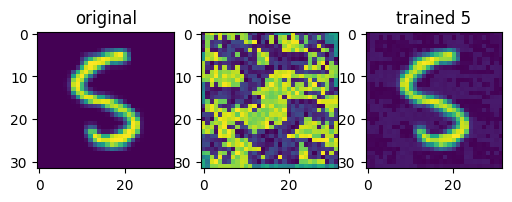

5
iter 1, loss = 0.028083311393857002


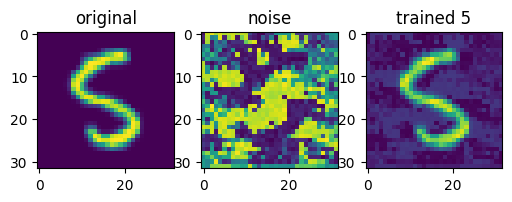

5
iter 3, loss = 0.22660663723945618


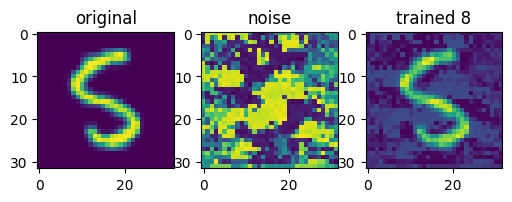

5
iter 5, loss = 1.4077622890472412


In [ ]:
check_attack(1235)

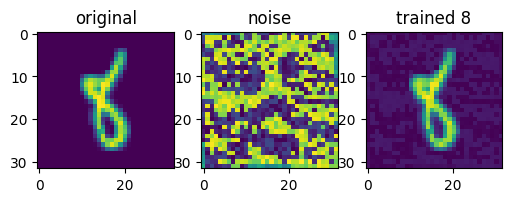

8
iter 1, loss = 0.2692389190196991


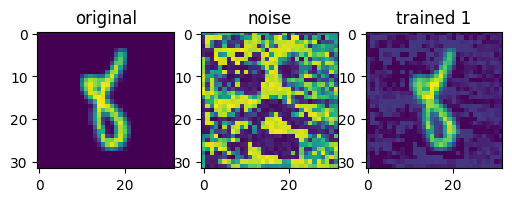

8
iter 3, loss = 1.5998022556304932


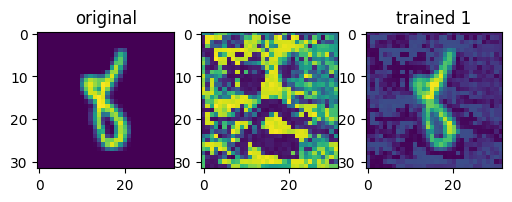

8
iter 5, loss = 4.102141857147217


In [ ]:
check_attack(5678)

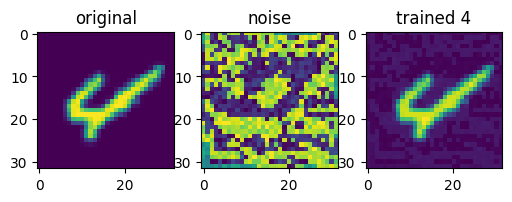

4
iter 1, loss = 0.03256803750991821


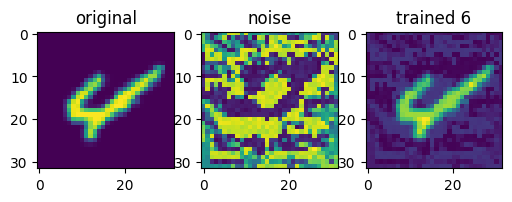

4
iter 3, loss = 0.32678207755088806


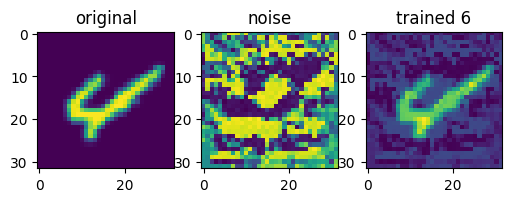

4
iter 5, loss = 1.5522414445877075


In [ ]:
check_attack(9012)